In [125]:
!pip install geomle

In [126]:
import sys
import os
from os import path
current_folder = path.dirname(path.abspath('')) 
sys.path.append(current_folder)
from estimators import *
from geomle import geomle, mle, DataGenerator
import multiprocessing as mp
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import cholesky
from scipy.special import gammainc, lambertw
import scipy.io
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import random
import time
import numpy as np
import pandas as pd
import pickle
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
import subprocess
from IPython.display import display_html
from operator import itemgetter
ig0 = itemgetter(0)
ig1 = itemgetter(1)
ig2 = itemgetter(2)
rpy2.robjects.numpy2ri.activate()
utils = rpackages.importr('utils')
#utils.install_packages('intrinsicDimension')
#utils.install_packages('ider')
intdimr = rpackages.importr('intrinsicDimension')
ider   = rpackages.importr('ider')
r_base = rpackages.importr('base')

In [136]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def mean_sqe(estimations, truth):
    '''
    Mean squared error 
    '''
    return ((estimations - truth)^2/truth).sum() /len(truth) 
    
def mean_pe(estimations, truth):
    '''
    Mean percentage error 
    '''
    return (abs(estimations - truth)/truth).sum() /len(truth)*100

def mean_ge(estimations, truth):
    '''
    Mean geometric error: The geometric mean of the error *ratio*. It is always >= 1.
    '''
    ratios = np.concatenate(((estimations/truth)[np.newaxis, :], (truth/estimations)[np.newaxis, :]), axis=0)
    return np.power(ratios.max(axis=0).prod(), 1.0/len(estimations))

def med_pe(estimations, truth):
    '''
    Median error in %.
    '''
    return np.percentile(abs(estimations - truth)/truth, q=50)*100


def randball(n_points,ndim,radius,center = []):
    ''' Generate uniformly sampled ndim-sphere interior'''
    if center == []:
        center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def proxy(tup):
    function,X,Dict = tup
    return function(X,**Dict)

def asPointwise(data,function, params, n_neighbors=100,n_cores=1):
    '''Use a global estimator as a pointwise one by creating kNN neighborhoods'''
    neigh = NearestNeighbors(n_neighbors)
    neigh.fit(data)
    knn   = neigh.kneighbors(return_distance=False)
    if n_cores > 1:
        pool = mp.Pool(n_cores)
        results = pool.map(proxy,[(function,data[i,:],params) for i in knn])
        pool.close()
        return results
    else:
        return [function(data[i,:],**params) for i in knn]

def dimension_uniform_ball_robust(py,alphas):
    '''modification to return selected index and handle the case where all values are 0'''
    if len(py)!=len(alphas[0,:]):
        raise ValueError('length of py (%i) and alpha (%i) does not match'%(len(py),len(alphas[0,:])))

    if np.sum(alphas <= 0) > 0 or np.sum(alphas >= 1) > 0:
        raise ValueError(['"Alphas" must be a real vector, with alpha range, the values must be within (0,1) interval'])

    #Calculate dimension for each alpha
    n = np.zeros((len(alphas[0,:])))
    for i in range(len(alphas[0,:])):
        if py[i] == 0:
            #All points are separable. Nothing to do and not interesting
            n[i]=np.nan
        else:
            p  = py[i]
            a2 = alphas[0,i]**2
            w = np.log(1-a2)
            n[i] = lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w)

    n[n==np.inf] = float('nan')
    #Find indices of alphas which are not completely separable 
    inds = np.where(~np.isnan(n))[0]
    if inds.size==0:
        n_single_estimate = np.nan
        alfa_single_estimate = np.nan
        return n,n_single_estimate,alfa_single_estimate
    else:
        #Find the maximal value of such alpha
        alpha_max = max(alphas[0,inds])
        #The reference alpha is the closest to 90 of maximal partially separable alpha
        alpha_ref = alpha_max*0.9
        k = np.where(abs(alphas[0,inds]-alpha_ref)==min(abs(alphas[0,:]-alpha_ref)))[0]
        #Get corresponding values
        alfa_single_estimate = alphas[0,inds[k]]
        n_single_estimate = n[inds[k]]

        return n,n_single_estimate,alfa_single_estimate,inds[k]

def point_inseparability_to_pointID(p_alpha,alphas=np.arange(.6,1,.02)[None], eps = 1e-100):
    '''returns point ID from point inseparability values, fitting all alphas:
    * instead of feeding mean point p_alphas and given alphas, we feed point p_alphas and given alphas to dimension_uniform_ball
    * dimension_uniform_ball_robust is used instead of the base function to handle all 0 case and returns chosen alphas index 
    '''
    
    #correct for 0 to avoid NaNs
    palphas_zero_corrected = p_alpha.T.copy()

    n_singles = np.zeros(len(palphas_zero_corrected))
    alpha_singles = np.zeros(len(palphas_zero_corrected))
    alpha_idx = np.zeros(len(palphas_zero_corrected))

    #for each point, check inseparability prob vector (one alpha-> one value)
    for i,palpha in enumerate(palphas_zero_corrected):
        n_alpha,n_singles[i],alpha_singles[i],alpha_idx[i] = dimension_uniform_ball_robust(palpha,alphas)
    return n_singles, alpha_singles, alpha_idx

def calculate_time(func): 
    def inner_func(*args, **kwargs): 
        begin = time.time() 
        res = func(*args, **kwargs) 
        end = time.time()
        return res, end - begin
    return inner_func

class DimEst():
    def __init__(self):
        self.names = ['MLE', 'GeoMLE', 'MIND', 'DANCo', 'FastDANCo', 'ESS', 'PCA', 'CD','FisherS','ANOVA','TwoNN']
        
    def estimateAllMethods(self, data):
        dim = data.shape[1]
        self.funcs = {'MLE':          self.mle(data),
                      #'GeoMLE':       self.geomle(data, dim),
                      'MiND':         self.mind_mlk(data, dim),
                      #'DANCo':        self.danco(data, dim),
                      'FastDANCo':    self.fast_danco(data),
                      'ESS':          self.ess(data),
                      #'PCA':          self.pca(data),
                      #'CD':           self.cd(data),
                      'FisherS':      self.fisherS(data),
                      'ANOVA':        self.anova(data),
                      'TwoNN':        self.twonn(data)
                     }
                      
        self.times = {key: ig1(val) for key, val in self.funcs.items()}
        self.funcs = {key: ig0(val) for key, val in self.funcs.items()}
        return self.funcs, self.times
    
    @staticmethod
    @calculate_time
    def mle(data):
        return mle(pd.DataFrame(data), k1=10, k2=20, average=True)[0].mean()
    
    @staticmethod
    @calculate_time
    def geomle(data, dim):
#         k1 =  k1_log(dim)
#         k2 =  k2_log(dim)
        return geomle(pd.DataFrame(data), k1=20, k2=55, nb_iter1=1, alpha=5e-3).mean()
    
    @staticmethod
    @calculate_time
    def mind_mlk(data, dim):
        return intdimr.dancoDimEst(data, k=(20 + 55) // 2, D=min(dim,100), ver="MIND_MLk").rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def danco(data, dim):
        return intdimr.dancoDimEst(data, k=(20 + 55) // 2, D=min(dim,100), ver="DANCo").rx2('dim.est')[0]

    @staticmethod
    @calculate_time
    def fast_danco(data):
        return runDANCo(data)[0]
    
    @staticmethod
    @calculate_time
    def ess(data):
        return intdimr.essLocalDimEst(data).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def pca(data):
        return intdimr.pcaLocalDimEst(data, 'FO').rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def cd(data):
        res = corint_py(data, k1=20, k2=55)
        return res[0]
    
    @staticmethod
    @calculate_time
    def fisherS(data):
        res = SeparabilityAnalysis(data,ProducePlots=0)
        return res[1][0]
    
    @staticmethod
    @calculate_time
    def anova(data):
        res = runANOVAglobal(data)
        return res[0,0]
    
    @staticmethod
    @calculate_time
    def twonn(data):
        res = twonn_py(data)
        return res

In [128]:
DE=DimEst()
DG=DataGenerator()

### Synthetic data

In [24]:
data=randsphere(500,2,1)[0]
data2 = DG.gen_data('Sphere', 500, 6, 1, 'uniform').to_numpy()
results = DE.estimateAllMethods(data)
estimates = results[0]
runtimes = results[1]

NameError: name 'DG' is not defined

In [122]:
estimates_table = pd.DataFrame(data=estimates.values(),index=estimates.keys(), columns=['Sphere'])
estimators_runtime = pd.DataFrame(data=runtimes.values(),index=runtimes.keys(), columns=['runtimes: Sphere'])
display_side_by_side(estimates_table,estimators_runtime)

,Sphere
MLE,1.922205
GeoMLE,2.000000
MiND,2.000000
DANCo,2.000000
ESS,2.045440
PCA,2.000000
CD,1.851376
FisherS,1.968292
ANOVA,2.000000
TwoNN,2.078121


### Real data

In [27]:
#load data
data_files = list(filter(lambda x: '.data' in x, os.listdir('../data/id-tle-real-data/data/real/')))
real_data = [np.array(pd.read_csv('../data/id-tle-real-data/data/real/'+file,sep=' ',header=None)) for file in data_files]
real_data=dict(zip(data_files,real_data))
real_data['isomapFaces'] = scipy.io.loadmat('../data/face_data.mat')['images'].T

In [10]:
print('Real datasets used in Intrinsic Dimensionality Estimation within Tight Localities:\n')
for key,_data in real_data.items():
    print(key+'\t'+str(_data.shape))

Real datasets used in Intrinsic Dimensionality Estimation within Tight Localities:

gisette.data	(7000, 5000)
mnist.data	(70000, 784)
msd.data	(515345, 90)
ann_sift1b.data	(1000000, 128)
aloi.data	(110250, 641)
covertype.data	(581012, 56)
isolet.data	(7797, 617)
bci5.data	(31216, 96)
isomapFaces	(698, 4096)


In [128]:
results = DE.estimateAllMethods(data)
estimates = results[0]
runtimes = results[1]

R[write to console]: Computing DANCo calibration data for N = 698, k = 37 for dimensions 1 to 100



In [131]:
estimates_table = pd.DataFrame(data=estimates.values(),index=estimates.keys(), columns=['isomapFaces'])
estimators_runtime = pd.DataFrame(data=runtimes.values(),index=runtimes.keys(), columns=['runtimes: isomapFaces'])
display_side_by_side(estimates_table,estimators_runtime)

,isomapFaces
MLE,4.626255
GeoMLE,0.000000
MiND,4.000000
DANCo,5.000000
ESS,7.534800
PCA,10.000000
CD,4.338892
FisherS,3.871932
ANOVA,6.000000
TwoNN,3.605244


### Global ID saturation analysis

In [143]:
dataset_name = 'mnist.data'
subsample_size = 1000
subsample = np.random.choice(len(real_data[dataset_name]),replace=False, size=subsample_size)
data = real_data['mnist.data'][subsample]
print('subsampled data:', data.shape)

subsampled data: (1000, 784)


In [144]:
# testing separability saturation

n_samples = data.shape[0]
n_repeats = 10

sample_sizes = [10,15,20,25,30,50,70,90]
sample_sizes_halves = [x/2 for x in sample_sizes]
all_sample_sizes = sample_sizes+sample_sizes_halves
all_sample_sizes = list(set(all_sample_sizes))
all_sample_sizes.sort()

print('Running subsampling analysis...\nSubsample percentages = {}\nNumber of repeats = {}\nNumber of samples = {}\nDimension = {}'.format(sample_sizes,n_repeats,n_samples,data.shape[1]))
print('----------------------------\n')

fisherS_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
ess_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
fastdanco_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
twonn_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
anova_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
mle_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
mind_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])

runtimes = []
for i,sz in enumerate(all_sample_sizes):
    sample_size = int(n_samples*sz/100)
    print('Sample size = {}'.format(sample_size))
    start_time = time.time()
    for j in range(0,n_repeats):
        sample = np.random.choice(n_samples,replace=False, size=sample_size)
        xs = data[sample,:]
        
        #Run estimators
        allres = DE.estimateAllMethods(xs)
        results = allres[0]
        runtimes.append(allres[1])
        
        #Store
        fisherS_dim_estimates[i,j] = results['FisherS']
        ess_dim_estimates[i,j] = results['ESS']
        fastdanco_dim_estimates[i,j] = results['FastDANCo']
        twonn_dim_estimates[i,j] = results['TwoNN']
        anova_dim_estimates[i,j] = results['ANOVA']
        mle_dim_estimates[i,j] = results['MLE']
        mind_dim_estimates[i,j] = results['MiND']


    print("Elapsed time = {}".format(time.time()-start_time))

allres = DE.estimateAllMethods(data)
results = allres[0]
runtimes.append(allres[1])

for i in range(0,n_repeats):
    fisherS_dim_estimates[len(all_sample_sizes),i] = results['FisherS']
    ess_dim_estimates[len(all_sample_sizes),i] = results['ESS']
    fastdanco_dim_estimates[len(all_sample_sizes),i] = results['FastDANCo']
    twonn_dim_estimates[len(all_sample_sizes),i] = results['TwoNN']
    anova_dim_estimates[len(all_sample_sizes),i] = results['ANOVA']
    mle_dim_estimates[len(all_sample_sizes),i] = results['MLE']
    mind_dim_estimates[len(all_sample_sizes),i] = results['MiND']


all_sample_sizes.append(100)
sample_sizes.append(100)

np.savetxt("../results/"+dataset_name+"_fisherS_dim_estimates.txt", fisherS_dim_estimates, delimiter="\t")
np.savetxt("../results/"+dataset_name+"_ess_dim_estimates.txt", ess_dim_estimates, delimiter="\t")
np.savetxt("../results/"+dataset_name+"_fastdanco_dim_estimates.txt", fastdanco_dim_estimates, delimiter="\t")
np.savetxt("../results/"+dataset_name+"_twonn_dim_estimates.txt", twonn_dim_estimates, delimiter="\t")
np.savetxt("../results/"+dataset_name+"_anova_dim_estimates.txt", anova_dim_estimates, delimiter="\t")
np.savetxt("../results/"+dataset_name+"_mle_dim_estimates.txt", mle_dim_estimates, delimiter="\t")
np.savetxt("../results/"+dataset_name+"_mind_dim_estimates.txt", mind_dim_estimates, delimiter="\t")

np.savetxt("../results/"+dataset_name+"_all_sample_sizes.txt", all_sample_sizes, delimiter="\t")
np.savetxt("../results/"+dataset_name+"_sample_sizes.txt", sample_sizes, delimiter="\t")
np.savetxt("../results/"+dataset_name+"_runtimes.txt", np.array(runtimes).reshape([len(all_sample_sizes)+1,n_repeats]), delimiter="\t")

Running subsampling analysis...
Subsample percentages = [10, 15, 20, 25, 30, 50, 70, 90]
Number of repeats = 10
Number of samples = 1000
Dimension = 784
----------------------------

Sample size = 50
Elapsed time = 72.2999198436737
Sample size = 75
Elapsed time = 86.28040623664856
Sample size = 100
Elapsed time = 87.87110567092896
Sample size = 125
Elapsed time = 79.46370339393616
Sample size = 150
Elapsed time = 87.55775260925293
Sample size = 200
Elapsed time = 84.10960412025452
Sample size = 250
Elapsed time = 88.03012871742249
Sample size = 300
Elapsed time = 94.83077383041382
Sample size = 350
Elapsed time = 98.44812536239624
Sample size = 450
Elapsed time = 114.3976936340332
Sample size = 500
Elapsed time = 113.93360877037048
Sample size = 700
Elapsed time = 121.39418625831604
Sample size = 900
Elapsed time = 141.81441068649292


fisherS_dim_estimates


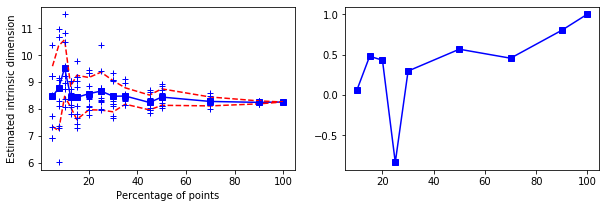

ess_dim_estimates


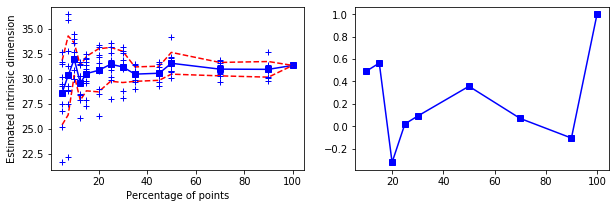

fastdanco_dim_estimates


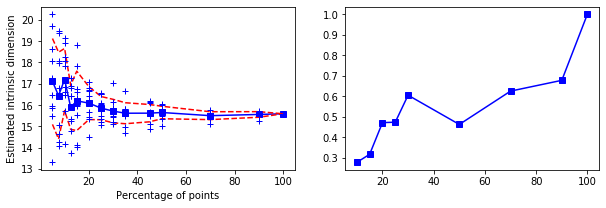

twonn_dim_estimates


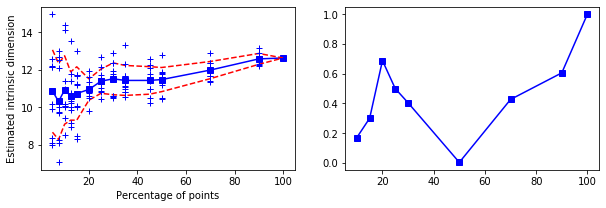

anova_dim_estimates


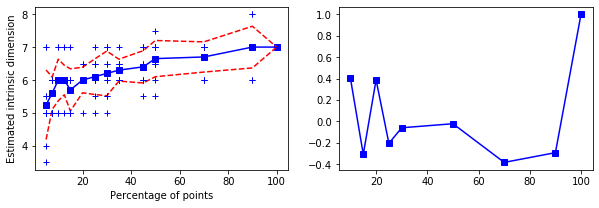

mle_dim_estimates


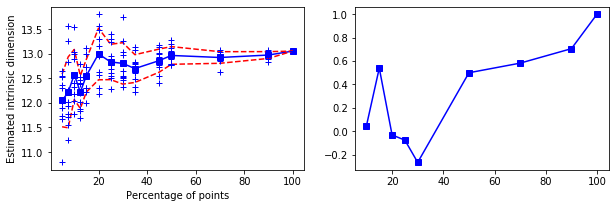

mind_dim_estimates


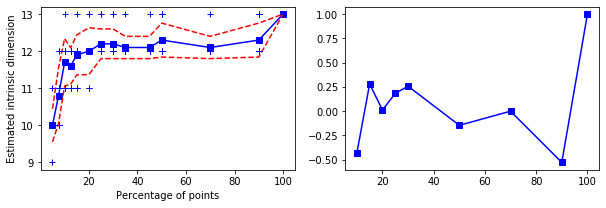

In [149]:
# plot convergence curve
alls=pd.read_csv('../results/'+dataset_name+'_all_sample_sizes.txt', sep='\t',header=None)
all_sample_sizes = alls.to_numpy()[:,0]
sizes=pd.read_csv('../results/'+dataset_name+'_sample_sizes.txt', sep='\t',header=None)
sample_sizes =sizes.to_numpy()[:,0]

estimators = ['fisherS_dim_estimates','ess_dim_estimates','fastdanco_dim_estimates',
              'twonn_dim_estimates','anova_dim_estimates','mle_dim_estimates','mind_dim_estimates']

for estimator in estimators:
    print(estimator)
    ds=pd.read_csv('../results/'+dataset_name+'_'+estimator+'.txt', sep='\t',header=None)
    dim_estimates=ds.to_numpy()

    mn = np.mean(dim_estimates[:,:],1)
    std = np.std(dim_estimates[:,:],1)

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(all_sample_sizes,mn,'bs-')
    plt.plot(all_sample_sizes,mn-std,'r--')
    plt.plot(all_sample_sizes,mn+std,'r--')
    plt.plot(all_sample_sizes,dim_estimates,'b+')
    plt.xlabel('Percentage of points')
    plt.ylabel('Estimated intrinsic dimension')

    ratios = []
    for sz in sample_sizes:
        sz_half = sz/2
        k = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz-asz)<0.001 ][0]
        k_half = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz_half-asz)<0.001 ][0]
        #print(k,all_sample_sizes[k],k_half,all_sample_sizes[k_half])
        ratios.append(1-std[k]/std[k_half])
        
    #avoid case of 0 std (nan ratio)
    ratios=np.array(ratios)
    ratios[np.isnan(ratios)]=1

    plt.subplot(122)
    plt.plot(sample_sizes,ratios,'bs-')
    plt.show()

### Study the behavior of the statistics used by the various estimators